In [1]:
from __future__ import division

import re
import math
import nltk
import string
import random
import numpy as np
import itertools as it
import tensorflow as tf
import cPickle as pickle
import scipy.sparse as ss
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
def load_corpus(file_path):
    """ Load corpus from text file and tokenize """
    corpus = []
    vocab_cnt = Counter()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    
    with open(file_path) as fd:
        for line in fd:
            # clean lines from any punctuation characters
            clean_line = re.sub('[\+\-\.\,\:\;\"\?\!\>\<\=\(\)\n]+', '', line)
            tokens = tokenizer.tokenize(clean_line.lower())
            corpus.append(tokens)
            vocab_cnt.update(tokens)
            
    return corpus, vocab_cnt


def code_tokens(vocab_cnt, corpus_size, min_occurrence=10, subsampling_t=1e-5, unk_symbol='<unk>'):
    """ Filter vocabulary and encode tokens """
    vocab = ['<unk>']
    
    # filter vocabulary with min_occurrences and subsampling
    for token, count in vocab_cnt.iteritems():
        token_prob = max(1 - math.sqrt(subsampling_t / (count / float(corpus_size))), 0)
        if count >= min_occurrence and np.random.rand() > token_prob:
            vocab.append(token)
    vocab_enc = {token: ix for ix, token in enumerate(vocab)}
    vocab_dec = {ix: token for token, ix in vocab_enc.iteritems()}
    
    return vocab, vocab_enc, vocab_dec


def generate_cooc_data(corpus, window_size=5, bidir_window=True):
    """ Generate data with context in format (target, context, distance) """
    for center_ix, center_val in enumerate(corpus):
        left_context = corpus[max(0, center_ix - window_size): center_ix]
        left_context_len = len(left_context)
        right_context = corpus[center_ix + 1: center_ix + window_size + 1]
        right_context_len = len(right_context)

        for context_ix, context_val in enumerate(left_context):
            distance = left_context_len - context_ix
            yield (center_val, context_val, distance)

        if bidir_window:
            for context_ix, context_val in enumerate(right_context):
                distance = context_ix + 1
                yield (center_val, context_val, distance)
                    
                    
# WEIGHTING FUNCTIONS
uniform_weight = lambda distance, length: 1.0
# proposed by Pennington, used for GloVe
harmonic_weight = lambda distance, length: 1.0 / distance
# proposed by Mikolov, used for word2vec
fraction_weight = lambda distance, length: float(distance) / length

def build_cooc_matrix(data_generator, vocab_size, window_size, weight_fn=uniform_weight):
    """ Build sparse cooccurrence matrix """
    cooc_matrix = ss.lil_matrix((vocab_size, vocab_size), dtype=np.float64)
    
    for target, context, distance in data_generator:
        cooc_matrix[target, context] += weight_fn(distance, window_size)
    return cooc_matrix.tocoo()


def iterate_sparse_matrix(sparse_matrix):
    """ Iterate a sparse COO matrix """
    return zip(sparse_matrix.row, sparse_matrix.col, sparse_matrix.data)


def generate_context_data(corpus, max_window_size=5, skip_size=1, flatten=True):
    """ Generate data with context in format (target, [contexts]) or (target, context) """
    for center_ix in xrange(max_window_size, len(corpus)-max_window_size, skip_size):
        # sample a window size for the given center word
        window_size = np.random.randint(max_window_size) + 1
        full_context = corpus[center_ix-window_size:center_ix] + corpus[center_ix+1: center_ix+window_size+1]
        
        if flatten:
            for context_ix in xrange(2*window_size):
                yield (corpus[center_ix], full_context[context_ix])
        else:
            yield(corpus[center_ix], full_context)
                
                
def batchify_data(data_generator, batch_size):
    """ Split dataset (generator) into batches """
    if isinstance(data_generator, list):
        for ix in xrange(0, len(data_generator), batch_size):
            yield zip(*data_generator[ix:ix+batch_size])
    else:
        while data_generator:
            buff = []
            for ix in xrange(0, batch_size):
                buff.append(next(data_generator))
            yield zip(*buff)


def save_embeddings(embeddings_obj, file_name):
    """ Save word embeddings and helper structures """
    with open(file_name, 'wb') as fd:
        pickle.dump(embeddings_obj, fd)
    

def load_embeddings(file_name):
    """ Load word embeddings and helper structures """
    with open(file_name, 'r') as fd:
        embeddings_obj = pickle.load(fd)
    return embeddings_obj
    
    
def get_tsne_embeddings(embedding_matrix):
    """ Compute t-SNE representation of embeddings """
    tsne = TSNE(perplexity=25, n_components=2, init='pca', n_iter=5000)
    return tsne.fit_transform(embedding_matrix)


def get_pca_embeddings(embedding_matrix):
    """ Compute PCA representation of embeddings """
    pca = PCA(n_components=2)
    return pca.fit_transform(embedding_matrix)


def plot_embeddings(embeddings, words=[], words_cnt=500, method='pca', figsize=(8,8)):
    """ Plot subset of embeddings in 2D space using t-SNE or PCA """
    embedding_matrix = embeddings._embeddings
    vocab_dec = embeddings._vocab_dec
    vocab_enc = embeddings._vocab_enc
    
    # prepare data
    if not words:
        vocab_size = embedding_matrix.shape[0]
        ixs = range(vocab_size)
        random.shuffle(ixs)
        chosen_ixs = ixs[:words_cnt]
        labels = [vocab_dec[ix] for ix in chosen_ixs]
        word_vecs = embedding_matrix[chosen_ixs]
    else:
        labels = words
        chosen_ixs = [vocab_enc[word] for word in words]
        word_vecs = embedding_matrix[chosen_ixs]
        
    if method == 'tsne':
        low_dim_embeddings = get_tsne_embeddings(word_vecs)
    else:
        low_dim_embeddings = get_pca_embeddings(word_vecs)
        
    # plot reduced vectors
    plt.figure(figsize=figsize)
    
    for embedding, label in zip(low_dim_embeddings, labels):
        x, y = embedding[0], embedding[1]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), 
                     textcoords='offset points', ha='right', 
                     va='bottom')
    plt.yticks=[]
    plt.xticks=[]
    plt.grid()
    plt.show()
    

class Embeddings(object):
    """ Class wrapping word embeddings """
    def __init__(self, embedding_matrix, vocab_enc, vocab_dec):
        self._embeddings = embedding_matrix
        self._vocab_enc = vocab_enc
        self._vocab_dec = vocab_dec
    
    def find_embedding(self, word):
        """ Find embedding for a given word """
        if isinstance(word, str):
            word = self._vocab_enc[word]
        return self._embeddings[word]
    
    def find_neighbors(self, word, k=5, nearest=True, exclude=[], include_scores=False):
        """ Find neighboring words (semantic regularities) """
        word_ix = self._vocab_enc[word]
        exclude = exclude + [word_ix]
        
        # find neighbors
        word_emb = self._embeddings[word_ix]
        similarities = self._embeddings.dot(word_emb)
        similarities[exclude] = 0
        best_matches = np.argsort(similarities)
        trimmed_matches = best_matches[-k:][::-1] if nearest else best_matches[:k]
        return [(self._vocab_dec[word_ix], similarities[word_ix]) for word_ix in trimmed_matches]
    
    def find_analogous(self, word_a, word_b, word_c, k=5):
        """ Find analogous word (syntactic regularities: word_a - word_b = x - word_c) """
        word_a_ix, word_b_ix, word_c_ix = [self._vocab_enc[word] for word in [word_a, word_b, word_c]]
        exclude = [word_a_ix, word_b_ix, word_c_ix]
        
        emb_a = self.find_embedding(word_a_ix) 
        emb_b = self.find_embedding(word_b_ix) 
        emb_c = self.find_embedding(word_c_ix) 
        emb_d_hat = emb_a - emb_b + emb_c
        similarities = self._embeddings.dot(emb_d_hat)
        similarities[exclude] = 0
        best_matches = np.argsort(similarities)
        trimmed_matches = best_matches[-k:][::-1]
        return [(self._vocab_dec[word_ix], similarities[word_ix]) for word_ix in trimmed_matches]
    
    def vocab(self):
        """ Return vocabulary list """
        return self._vocab_enc.keys()

## Load Corpus

Corpus size (total tokens): 47
Corpus vocabulary size (distinct tokens): 19
Most popular words: [('graph', 5), ('trees', 5), ('i', 4), ('system', 4), ('user', 3)]


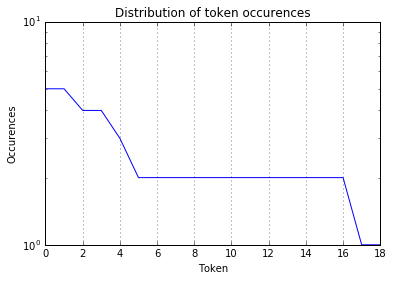

In [3]:
#TEXT_FILE = './corpora/trump-clean.txt'
#TEXT_FILE = './corpora/presidential-clean.txt'
#TEXT_FILE = './corpora/reviews-clean.txt'
#TEXT_FILE = './corpora/reviews-clean-small.txt'
#TEXT_FILE = './corpora/reviews-clean-xsmall.txt'
TEXT_FILE = './corpora/amund.txt'

# LOAD CORPUS AND SHOW STATS
corpus, vocab_cnt = load_corpus(TEXT_FILE)
raw_corpus_size = sum(vocab_cnt.itervalues())
raw_vocab_size = len(vocab_cnt)

print 'Corpus size (total tokens):', raw_corpus_size
print 'Corpus vocabulary size (distinct tokens):', raw_vocab_size
print 'Most popular words:', vocab_cnt.most_common(5)

# visualize distribution
counts = sorted(vocab_cnt.itervalues(), reverse=True)
plt.semilogy(range(len(counts)), counts)
plt.title('Distribution of token occurences')
plt.xlabel('Token')
plt.ylabel('Occurences')
plt.grid()
plt.show()

In [4]:
# FILTER LESS POPULAR TOKENS AND ENCODE TOKENS
MIN_OCC = 0
vocab, vocab_enc, vocab_dec = code_tokens(vocab_cnt, raw_corpus_size, min_occurrence=MIN_OCC, subsampling_t=1e-0)
vocab_size = len(vocab)
corpus_enc = [vocab_enc[word] for sentence in corpus for word in sentence if word in vocab_enc]
#del corpus # for memory saving

print 'Clean corpus size (w/o less freq words):', len(corpus_enc)
print 'Clean vocabulary size (w/o less freq words):', vocab_size

Clean corpus size (w/o less freq words): 47
Clean vocabulary size (w/o less freq words): 20


## word2vec

In [ ]:
class word2vec(object):
    def __init__(self, embed_size, vocab_size, batch_size=128, num_neg_samples=64):
        self._embed_size = embed_size
        self._vocab_size = vocab_size
        self._batch_size = batch_size
        self._num_neg_samples = num_neg_samples
        
    def _setup_variables(self, learning_rate):
        self._graph = tf.Graph()
        
        with self._graph.as_default():
            # declare input/output placeholders
            self._target_labels = tf.placeholder(tf.int32, shape=[self._batch_size], name='target_labels')
            self._context_labels = tf.placeholder(tf.int32, shape=[self._batch_size, 1], name='context_labels')
            
            # declare weight/embedding matrices
            embeddings = tf.Variable(tf.random_uniform([self._vocab_size, self._embed_size], 1.0, -1.0),
                                       name='input_embeddings')
            softmax_w = tf.Variable(tf.truncated_normal([self._vocab_size, self._embed_size], stddev=1.0/math.sqrt(self._embed_size)), 
                                        name='softmax_weights')
            softmax_b = tf.Variable(tf.zeros([self._vocab_size]), name='softmax_biases')
            
            
            # lookup target/context embeddings
            target_embeds = tf.nn.embedding_lookup(embeddings, self._target_labels)
            
            # skip-gram negative sampling loss
            individual_losses = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, self._context_labels, 
                                                           target_embeds, self._num_neg_samples, 
                                                           self._vocab_size)
            
            # average loss in the batch
            self._total_loss = tf.reduce_mean(individual_losses)
            
            # setup optimizer and logging
            self._optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(self._total_loss)
            
            # misc settings
            norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
            self._normalized_embeddings = embeddings / norm
            
            tf.summary.scalar("Skipgram_loss", self._total_loss)
            self._summary = tf.summary.merge_all()
            
    def train(self, data, max_epochs=25, learning_rate=0.05, window_size=5, skip_size=2, log_dir='./logs'):
        print 'Initializing variables...'
        self._setup_variables(learning_rate)
        
        training_step = 0
        with tf.Session(graph=self._graph) as session:
            tf.global_variables_initializer().run()
            summary_writer = tf.summary.FileWriter(log_dir, graph=session.graph)
            
            for epoch in xrange(max_epochs):
                data_generator = generate_context_data(data, window_size, skip_size)
                data_batches = list(batchify_data(data_generator, self._batch_size))
                random.shuffle(data_batches)
                
                epoch_loss, batch_count = 0, 0
                for targets, contexts in tqdm(data_batches):
                    if len(targets) != self._batch_size: continue
                    
                    targets = np.array(targets)
                    contexts = np.array(contexts).reshape(-1, 1)
                        
                    feed_dict = {
                        self._target_labels: targets,
                        self._context_labels: contexts,
                    }
                    _, total_loss, summary_str = session.run([self._optimizer, self._total_loss, 
                                                              self._summary], feed_dict=feed_dict)
                    
                    if training_step % 5000 == 0: summary_writer.add_summary(summary_str, training_step)
                        
                    epoch_loss += total_loss
                    batch_count += 1
                    training_step += 1
                tqdm.write('Epoch {} - avg loss: {}'.format(epoch, epoch_loss / batch_count))
                self.word_embeddings = self._normalized_embeddings.eval()
                
            # combine and store word embeddings
            self.word_embeddings = self._normalized_embeddings.eval()

#### Train and Inspect

In [ ]:
WINDOW_SIZE = 5
SKIP_SIZE = 1
MAX_EPOCHS = 5
BATCH_SIZE = 256
EMBED_SIZE = 50
LEARNING_RATE = 1.0
VOCAB_SIZE = len(vocab)

skipgram = word2vec(EMBED_SIZE, VOCAB_SIZE, batch_size=BATCH_SIZE)
skipgram.train(corpus_enc, MAX_EPOCHS, LEARNING_RATE)

In [ ]:
emb_w2v = Embeddings(skipgram.word_embeddings, vocab_enc, vocab_dec)
print emb_w2v.find_neighbors('sun', nearest=True)
print emb_w2v.find_analogous('easiest', 'easy', 'good')

In [ ]:
plot_embeddings(skipgram.word_embeddings, vocab_dec, 100)

In [ ]:
file_name = 'w2v-airs-{}ep-{}lr-{}win-{}sk-{}bat-{}emb.em'.format(MAX_EPOCHS, LEARNING_RATE, WINDOW_SIZE, SKIP_SIZE, BATCH_SIZE, EMBED_SIZE)
save_embeddings(emb_w2v, file_name)

In [ ]:
for x in tqdm(xrange(5)): pass

## GloVe

In [6]:
class GloVe(object):
    def __init__(self, embed_size, vocab_size, batch_size=256, alpha_factor=0.75, occur_max=100, 
                 window_size=10, bidir_window=True):
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        
        self.alpha_factor = alpha_factor
        self.occur_max = occur_max
        self.window_size = window_size
        self.bidir_window = True
        
    def _setup_variables(self, learning_rate):
        self._graph = tf.Graph()
        
        with self._graph.as_default():
            # declare model constants
            # threshold of occurrences for the cost fn. weighting factor
            occur_max = tf.constant([self.occur_max], shape=[self.batch_size], 
                                    dtype=tf.float32, name='max_occurrences')
            # exponent of the cost fn. weighting factor
            alpha_factor = tf.constant([self.alpha_factor], dtype=tf.float32,
                                       name='alpha_factor')
        
            # declare input/output placeholders
            self._target_words = tf.placeholder(tf.int32, shape=[self.batch_size],
                                              name='target_words')
            self._context_words = tf.placeholder(tf.int32, shape=[self.batch_size],
                                                name='context_words')
            self._cooc_counts = tf.placeholder(tf.float32, shape=[self.batch_size],
                                              name='cooccurrence_counts')
            
            # declare weight/embedding matrices
            target_embeds = tf.Variable(tf.random_uniform([self.vocab_size, self.embed_size], 1.0, -1.0),
                                       name='target_embeddings')
            context_embeds = tf.Variable(tf.random_uniform([self.vocab_size, self.embed_size], 1.0, -1.0),
                                       name='context_embeddings')
            
            target_biases = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0),
                                       name='target_biases')
            context_biases = tf.Variable(tf.random_uniform([self.vocab_size], 1.0, -1.0),
                                       name='context_biases')
            
            # lookup target/context embeddings
            target_embed = tf.nn.embedding_lookup([target_embeds], self._target_words)
            target_bias = tf.nn.embedding_lookup([target_biases], self._target_words)
            context_embed = tf.nn.embedding_lookup([context_embeds], self._context_words)
            context_bias = tf.nn.embedding_lookup([context_biases], self._context_words)
            
            # glove algorithm computations
            # weighting factor f(x) of the cost fn. balances out the negative effect of rare and popular words
            weighting_factor = tf.minimum(1.0, tf.pow(tf.div(self._cooc_counts, occur_max), alpha_factor))
            embedding_product = tf.reduce_sum(tf.multiply(target_embed, context_embed), 1)
            # distance between embeddings including their biases and the log cooccurrence count
            embedding_distance = tf.square(embedding_product + target_bias + context_bias - tf.log(self._cooc_counts))
            
            # losses for each element in the batch
            individual_losses = tf.multiply(weighting_factor, embedding_distance)
            # average loss in the batch
            self._total_loss = tf.reduce_sum(individual_losses)
            # combined word embeddings
            self._combined_embeddings = tf.add(target_embeds, context_embeds, name='combined_embeddings')
            
            # setup optimizer and logging
            self._optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(self._total_loss)
            
            tf.summary.scalar("GloVe_loss", self._total_loss)
            self._summary = tf.summary.merge_all()
            
            
    def train(self, cooc_matrix, max_epochs=25, init_learning_rate=0.05, log_dir='./logs'):
        print 'Initializing variables...'
        self._setup_variables(init_learning_rate)
        print 'Preparing batched data...'
        data_batches = list(batchify_data(iterate_sparse_matrix(cooc_matrix), self.batch_size))
        
        training_step = 0
        with tf.Session(graph=self._graph) as session:
            tf.global_variables_initializer().run()
            summary_writer = tf.summary.FileWriter(log_dir, graph=session.graph)
            
            for epoch in xrange(max_epochs):
                random.shuffle(data_batches)
                
                epoch_loss = 0
                for targets, contexts, coocs in tqdm(data_batches):
                    if len(targets) != self.batch_size: continue
                        
                    feed_dict = {
                        self._target_words: targets,
                        self._context_words: contexts,
                        self._cooc_counts: coocs
                    }
                    _, total_loss, summary_str = session.run([self._optimizer, self._total_loss, self._summary], 
                                                             feed_dict=feed_dict)
                    if training_step % 5000 == 0:
                        summary_writer.add_summary(summary_str, training_step)
                        
                    epoch_loss += total_loss
                    training_step += 1
                print 'Epoch {} - avg loss: {}'.format(epoch, epoch_loss / len(data_batches))
                embeddings = self._combined_embeddings.eval()
                embeddings /= np.linalg.norm(embeddings, axis=1).reshape(-1, 1)
                self.word_embeddings = embeddings
                
            # combine and store word embeddings
            embeddings = self._combined_embeddings.eval()
            embeddings /= np.linalg.norm(embeddings, axis=1).reshape(-1, 1)
            self.word_embeddings = embeddings

#### Train and Inspect

In [9]:
WINDOW_SIZE = 5
MAX_EPOCHS = 50
EMBED_SIZE = 10
VOCAB_SIZE = len(vocab)

print 'Generating cooccurrence data'
cooc_generator = generate_cooc_data(corpus_enc, bidir_window=False)
print 'Generating cooccurrence matrix'
cooc_matrix = build_cooc_matrix(cooc_generator, VOCAB_SIZE, WINDOW_SIZE, weight_fn=harmonic_weight)
glove = GloVe(EMBED_SIZE, VOCAB_SIZE)
glove.train(cooc_matrix, MAX_EPOCHS)

Generating cooccurrence data
Generating cooccurrence matrix
Initializing variables...
Preparing batched data...


100%|██████████| 1/1 [00:00<00:00, 6574.14it/s]


Epoch 0 - avg loss: 0.0
Epoch 1 - avg loss: 0.0
Epoch 2 - avg loss: 0.0
Epoch 3 - avg loss: 0.0
Epoch 4 - avg loss: 0.0
Epoch 5 - avg loss: 0.0
Epoch 6 - avg loss: 0.0
Epoch 7 - avg loss: 0.0
Epoch 8 - avg loss: 0.0
Epoch 9 - avg loss: 0.0
Epoch 10 - avg loss: 0.0
Epoch 11 - avg loss: 0.0
Epoch 12 - avg loss: 0.0
Epoch 13 - avg loss: 0.0
Epoch 14 - avg loss: 0.0
Epoch 15 - avg loss: 0.0
Epoch 16 - avg loss: 0.0
Epoch 17 - avg loss: 0.0
Epoch 18 - avg loss: 0.0
Epoch 19 - avg loss: 0.0
Epoch 20 - avg loss: 0.0
Epoch 21 - avg loss: 0.0
Epoch 22 - avg loss: 0.0
Epoch 23 - avg loss: 0.0
Epoch 24 - avg loss: 0.0


100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]


Epoch 25 - avg loss: 0.0
Epoch 26 - avg loss: 0.0
Epoch 27 - avg loss: 0.0
Epoch 28 - avg loss: 0.0
Epoch 29 - avg loss: 0.0
Epoch 30 - avg loss: 0.0
Epoch 31 - avg loss: 0.0
Epoch 32 - avg loss: 0.0
Epoch 33 - avg loss: 0.0
Epoch 34 - avg loss: 0.0
Epoch 35 - avg loss: 0.0
Epoch 36 - avg loss: 0.0
Epoch 37 - avg loss: 0.0
Epoch 38 - avg loss: 0.0
Epoch 39 - avg loss: 0.0
Epoch 40 - avg loss: 0.0
Epoch 41 - avg loss: 0.0
Epoch 42 - avg loss: 0.0
Epoch 43 - avg loss: 0.0
Epoch 44 - avg loss: 0.0
Epoch 45 - avg loss: 0.0
Epoch 46 - avg loss: 0.0
Epoch 47 - avg loss: 0.0
Epoch 48 - avg loss: 0.0
Epoch 49 - avg loss: 0.0


In [10]:
emb_glove = Embeddings(glove.word_embeddings, vocab_enc, vocab_dec)
print glove.word_embeddings.shape
print emb_glove.find_neighbors('graph', nearest=True)
#print emb_glove.find_analogous('best', 'good', 'easy')

(20, 10)
[('system', 0.79635644), ('i', 0.5991568), ('<unk>', 0.59339547), ('trees', 0.58150041), ('survey', 0.43870816)]


In [ ]:
plot_embeddings(glove.word_embeddings, vocab_dec, 10)

In [ ]:
file_name = 'g_airxs-{}ep-{}lr-{}win-{}sk-{}bat-{}emb.em'.format(MAX_EPOCHS, LEARNING_RATE, WINDOW_SIZE, SKIP_SIZE, BATCH_SIZE, EMBED_SIZE)
save_embeddings(emb_glove, file_name)

## Experiments

In [ ]:
#embeddings_path = './embeddings/g_airs-25ep-1.0lr-5win-1sk-256bat-50emb.em'
#embeddings_path = './embeddings/g_airs-25ep-1.0lr-5win-1sk-256bat-100emb.em'
#embeddings_path = './embeddings/w2v-airs-5ep-1.0lr-5win-1sk-256bat-50emb.em'
embeddings_path = './embeddings/w2v-airs-5ep-1.0lr-5win-1sk-256bat-100emb.em'

emb = load_embeddings(embeddings_path)
#emb2 = Embeddings(emb._embeddings, emb._vocab_enc, emb._vocab_dec)
#save_embeddings(emb2, embeddings_path)

emb._embeddings.shape

In [ ]:
test_vocab = ['bathroom', 'kitchen', 'bedroom', 'garage', 'garden', 'patio',
             'roger', 'anne', 'emily', 'tom', 'david', 'caroline', 'dean', 'greg',
             'diner', 'restaurant', 'bar', 'cafe', 'pub', 'club',
             'cozy', 'clean', 'warm', 'pretty', 'welcoming', 'homelike',
             'american', 'german', 'polish', 'spanish', 'irish', 'russian',
             'berlin', 'seattle', 'london', 'amsterdam', 'miami',
             'suffered', 'talked', 'round', 'worn', 'run', 'staples']

In [ ]:
plot_embeddings(emb, words=test_vocab, method='pca')

In [ ]:
emb.find_analogous('best', 'good', 'hot')

In [ ]:
emb.find_analogous('cleanest', 'clean', 'good')

In [ ]:
emb.find_analogous('king', 'man', 'woman')

In [ ]:
emb.find_neighbors('bathroom')

In [ ]:
emb.find_neighbors('car')

In [ ]:
emb.find_neighbors('view')